## 数字图像处理第四章

- Given an image, program for implementing its 2-D Fourier Transform and plotting its corresponding spectrum. 

- Program for implementing a Gaussian filter in the Frequency Domain based on the Seven Steps. ( Require to give some examples)

- Program for implementing three typical filters ( Ideal, Butterworth and Gaussian ) in the Frequency Domain for image smoothing and sharpening. 

- Program for implementing a selective filtering based on the frequency interval.

In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import math

(150, 150)


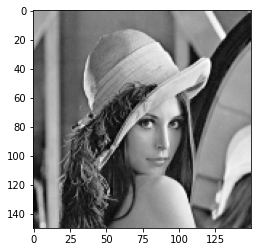

In [ ]:
img = cv2.imread('/content/drive/My Drive/数字图像处理/Image/Lenna.jpg', cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (150, 150))
print(img.shape)
plt.imshow(img, cmap='gray')


### DFT

$$
F(u, v) = \sum_{x=0}^{M-1}\sum_{y=0}^{N-1}f(x, y)e^{-j2\pi (ux/M + vy/N)}
$$
$$
f(x, y) = \frac{1}{MN}\sum_{u=0}^{M-1}\sum_{v=0}^{N-1}F(u, v)e^{j2\pi (ux/M + vy/ N)}
$$

In [ ]:
'''
用矩阵乘法代替循环的加速普通傅立叶变换计算(DFT)
'''
def fourier_transform(img):
  imgx = np.zeros(img.shape)
  h, w = img.shape
  F = np.zeros(shape=(h, w), dtype='complex128')

  for i in range(h):
    for j in range(w):
      imgx[i, j] = (-1)**(i + j) * img[i, j]

  xx = np.arange(h).reshape((-1, 1))
  yy = np.arange(w)

  for u in range(h):
    for v in range(w):
      # sums = 0
      # for x in range(h):
      #   for y in range(w):
      #     sums += (-1)**(x + y) * img[x, y] * np.exp(-1.j * 2 * np.pi * (u * x / h + v * y / w))
      sums1 = np.sum(imgx * np.exp(-1.j * 2 * np.pi * (u * xx / h + v * yy / w)))
      F[u, v] = sums1
  return F

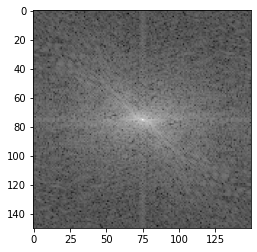

In [ ]:
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
fimg = np.log(1 + np.abs(fshift))
plt.imshow(fimg, cmap='gray')

In [ ]:
# my solution
out = fourier_transform(img)

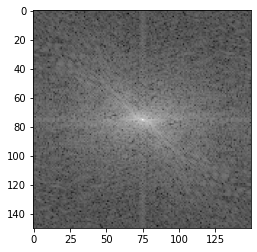

In [ ]:
log_F = np.log(1 + np.abs(out))
plt.imshow(log_F, cmap='gray')

### 频率域实现高斯低通滤波

In [ ]:
'''
傅立叶反变换(IDFT)
'''
def i_fourier_transform(F):
  h, w = F.shape
  img = np.zeros(shape=(h, w))

  uu = np.arange(h).reshape((-1, 1))
  vv = np.arange(w)

  for x in range(h):
    for y in range(w):
      # sums = 0
      # for u in range(h):
      #   for v in range(w):
      #     sums += F[x, y] * np.exp(1.j * 2 * np.pi * (u * x / h + v * y / w))
      sums1 = np.sum(F * np.exp(1.j * 2 * np.pi * (x * uu / h + y * vv / w)))
      img[x, y] = sums1.real * (-1)**(x + y)
  return img

高斯低通滤波器
$H(u, v) = e^{-D^2(u, v)/2D_0^2}$

In [ ]:
def gaussian_lowpass_filter(d, img, n=2):
  h, w = img.shape
  centerx, centery = h//2, w//2

  F = fourier_transform(img)
  for i in range(h):
    for j in range(w):
      def dist(raw, col):
        return math.sqrt((raw-centerx)**2 + (col-centery)**2)
      F[i, j] = F[i,j] * np.exp((-dist(i,j)**2)/(2*d**2))
  return i_fourier_transform(F)

In [ ]:
glp_60_img = gaussian_lowpass_filter(60, img)

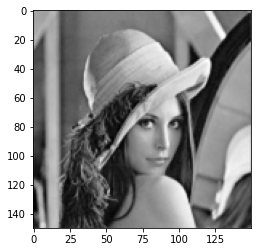

In [ ]:
plt.imshow(glp_60_img, cmap='gray')

### Ideal, Butterworth and Gaussian

理想低通滤波器
$$
H(u, v)=\begin{cases}
1& D(u, v)\leq D_0\\
0& D(u, v) > D_0
\end{cases}
$$

In [ ]:
def ilp_filter(d, img):
  h, w = img.shape
  centerx, centery = h//2, w//2

  F = fourier_transform(img)
  for i in range(h):
    for j in range(w):
      def dist(raw, col):
        return math.sqrt((raw-centerx)**2 + (col-centery)**2)
      if dist(i, j) > d:
        F[i, j] = 0
  return i_fourier_transform(F)

In [ ]:
ilp_10_img = ilp_filter(10, img)
ilp_50_img = ilp_filter(50, img)

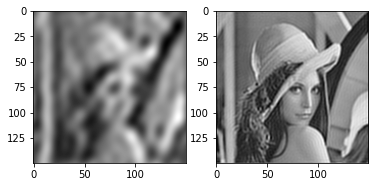

In [ ]:
plt.subplot(1, 2, 1)
plt.imshow(ilp_10_img, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(ilp_50_img, cmap='gray')

butterworth低通滤波器
$$
H(u, v)=\frac{1}{1 + [D(u, v)/D_0]^{2n}}
$$

In [ ]:
def butterworth_lowpass_filter(d, img, n=2):
  h, w = img.shape
  centerx, centery = h//2, w//2

  F = fourier_transform(img)
  for i in range(h):
    for j in range(w):
      def dist(raw, col):
        return math.sqrt((raw-centerx)**2 + (col-centery)**2)
      F[i, j] = F[i, j] * 1 / (1 + (dist(i,j)/d)**(2*n))
  return i_fourier_transform(F)

In [ ]:
bwlp_10_img = butterworth_lowpass_filter(10, img)
bwlp_60_img = butterworth_lowpass_filter(60, img)

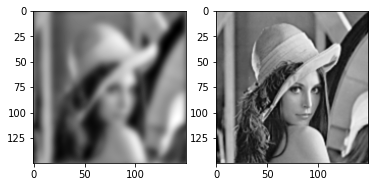

In [ ]:
plt.subplot(1, 2, 1)
plt.imshow(bwlp_10_img, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(bwlp_60_img, cmap='gray')

高斯高通滤波器
$$
H(u, v)=1 - e^{-D^2(u, v)/2D_0^2}
$$

In [ ]:
def gaussian_highpass_filter(d, img, n=2):
  h, w = img.shape
  centerx, centery = h//2, w//2

  F = fourier_transform(img)
  for i in range(h):
    for j in range(w):
      def dist(raw, col):
        return math.sqrt((raw-centerx)**2 + (col-centery)**2)
      F[i, j] = F[i,j] * (1 - np.exp((-dist(i,j)**2)/(2*d**2)))
  return i_fourier_transform(F)

In [ ]:
ghp_10_img = gaussian_highpass_filter(10, img)
ghp_60_img = gaussian_highpass_filter(60, img)

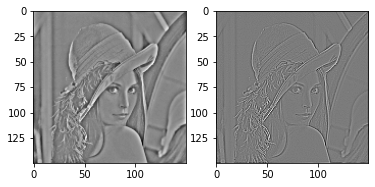

In [ ]:
plt.subplot(1, 2, 1)
plt.imshow(ghp_10_img, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(ghp_60_img, cmap='gray')

### 选择性滤波

带阻滤波器

理想：
$$
H(u, v)=\begin{cases}
0& D_0 - W/2 \leq D(u, v)\leq D_0 + W/2\\
1& other
\end{cases}
$$

带通滤波器

理想：1 -带阻滤波器


In [ ]:
def ibandreject_filter(d, W, img):
  h, w = img.shape
  centerx, centery = h//2, w//2

  F = fourier_transform(img)
  for i in range(h):
    for j in range(w):
      def dist(raw, col):
        return math.sqrt((raw-centerx)**2 + (col-centery)**2)
      if dist(i, j) >= d - W /2 and dist(i, j) <= d + W / 2:
        F[i, j] = 0
  return i_fourier_transform(F)

In [ ]:
ibr_img = ibandreject_filter(5, 6, img)

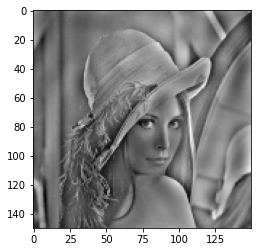

In [ ]:
plt.imshow(ibr_img, cmap='gray')